#  LEAF DISEASE DETECTION

### Disease detection in plants plays a very important role in the field of agriculture. This Data Science project aims to provide an image-based automatic inspection interface. It involves the use of self designed image processing and deep learning techniques. It will categorize plant leaves as healthy or infected.

#### Install and import all necessary libraries and packages
OpenCV (Open Source Computer Vision Library) is u
sed for computer vision and image processing tasks.
TensorFlow is a popular deep learning framework used to build and train neural networks.

In [1]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [3]:
pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#### Setting up and define initial parameters

In [5]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = "D:/MSc Data Science/Semester 3/Extra Works/Code Alpha/archive (12).zip"
width=256
height=256
depth=3

#### Define function to convert image to arrays

In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None



#### Extracting ZIP file

In [7]:
import zipfile
import os

# Define the path to the ZIP file and extraction directory
zip_file_path = r'D:\MSc Data Science\Semester 3\Extra Works\Code Alpha\archive (12).zip'
extracted_dir_path = r'D:\MSc Data Science\Semester 3\Extra Works\Code Alpha\PlantVillage'

In [8]:
# Create the directory for extraction if it doesn't exist
if not os.path.exists(extracted_dir_path):
    os.makedirs(extracted_dir_path)

In [9]:
# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [10]:
# Now use the extracted directory for loading images
directory_root = extracted_dir_path


#### Loading and processing images

In [11]:
# Proceed with the image loading code
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = [d for d in os.listdir(directory_root) if d != ".DS_Store"]

    for plant_folder in root_dir:
        plant_disease_folder_list = [d for d in os.listdir(os.path.join(directory_root, plant_folder)) if d != ".DS_Store"]

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = [f for f in os.listdir(os.path.join(directory_root, plant_folder, plant_disease_folder)) if f != ".DS_Store"]

            for image_name in plant_disease_image_list[:200]:
                image_directory = os.path.join(directory_root, plant_folder, plant_disease_folder, image_name)
                if image_directory.lower().endswith(('.jpg', '.jpeg')):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  

except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing PlantVillage ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


#### Preparing data for model training

In [12]:
image_size = len(image_list)

In [13]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)


In [14]:
print(label_binarizer.classes_)


['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [15]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0


In [16]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


#### Data augmentation

In [17]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")


#### Building a CNN model

In [18]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

C:\Users\adith\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 85, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 85, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 85, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 85, 85, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 85, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 85, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 42, 42, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 58,102,671 (221.64 MB)

 Trainable params: 58,099,791 (221.63 MB)

 Non-trainable params: 2,880 (11.25 KB)

#### Compiling and training the model

In [20]:
from keras.optimizers import Adam

# Define your initial learning rate and number of epochs
INIT_LR = 0.01  
EPOCHS =  10     

# Create Adam optimizer
opt = Adam(learning_rate=INIT_LR)

# Compile the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the network
print("[INFO] training network...")


[INFO] training network...


In [21]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10


C:\Users\adith\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.1888 - loss: 0.5848 - val_accuracy: 0.0745 - val_loss: 24.6769
Epoch 2/10
 1/73 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - accuracy: 0.1875 - loss: 0.3450

C:\ProgramData\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.1875 - loss: 0.3450 - val_accuracy: 0.0745 - val_loss: 21.9958
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.2711 - loss: 0.2942 - val_accuracy: 0.1523 - val_loss: 0.6608
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.5312 - loss: 0.1771 - val_accuracy: 0.1523 - val_loss: 0.6765
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.3223 - loss: 0.2604 - val_accuracy: 0.2453 - val_loss: 0.3633
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.4375 - loss: 0.2065 - val_accuracy: 0.2369 - val_loss: 0.3688
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.3839 - loss: 0.2285 - val_accuracy: 0.2843 - val_loss: 0.3009
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.3750 - loss: 0.2385 - val_accuracy: 0.2724 - val_loss: 0.2993
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.3946 - loss: 0.2142 - val_accuracy: 0.1015 - val

#### Visualizing the training model

In [22]:
# Print available keys to debug
print("Available keys in history.history:", history.history.keys())

Available keys in history.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


<Figure size 640x480 with 0 Axes>

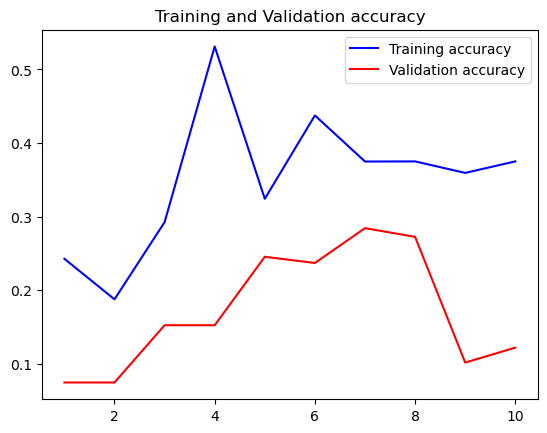

<Figure size 640x480 with 0 Axes>

In [24]:
# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

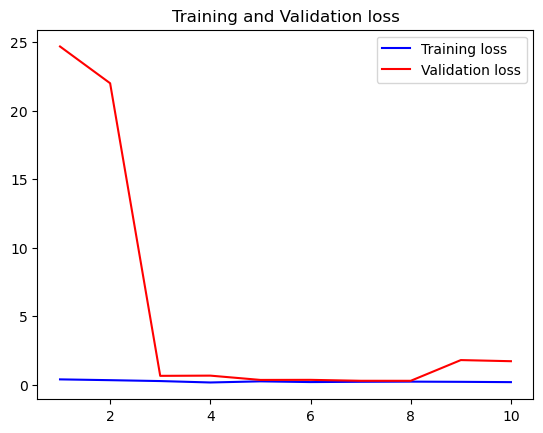

In [25]:
# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


#### Evaluating and saving the model

In [26]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))


loaded_model = pickle.load(open('cnn_model.pkl', 'rb'))

[INFO] Calculating model accuracy
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step - accuracy: 0.1109 - loss: 1.8120
Test Accuracy: 12.182740867137909
[INFO] Saving model...


#### Loading and using the model for prediction

In [27]:
loaded_model = pickle.load(open('D:\MSc Data Science\Semester 3\Extra Works\Code Alpha\cnn_model.pkl', 'rb'))

In [28]:
import numpy as np
import cv2  # Ensure you have OpenCV installed for image processing

# Function to convert image to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (256, 256))  # Resize to 256x256
            return image
        else:
            print(f"Error: Unable to load image at {image_dir}")
            return None
    except Exception as e:
        print(f"Error: {str(e)}")
        return None


In [70]:
# Path to your image file
image_dir = r"D:\MSc Data Science\Semester 3\Extra Works\Code Alpha\PlantVillage\PlantVillage\Tomato_Late_blight\0c47de5b-adbe-479f-8ccf-5b8c530c32f8___RS_Late.B 6312.JPG"

In [71]:
# Convert the image to array
im = convert_image_to_array(image_dir)


In [72]:
# Check if the image conversion was successful
if im is not None:
    np_image_li = np.array(im, dtype=np.float16) / 255.0  # Normalize the image
    npp_image = np.expand_dims(np_image_li, axis=0)  # Expand dimensions to match model input shape
 # Predict using the loaded model
    result = model.predict(npp_image)
    print(result)
else:
    print("Failed to process the image.")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[[3.8475272e-09 1.5161593e-01 9.5336304e-08 2.1107786e-12 3.0712013e-11
  7.4017534e-15 4.8518409e-06 8.4837842e-01 3.2027279e-09 4.9114606e-09
  1.3018950e-15 2.3449258e-14 6.6858314e-07 1.7814952e-09 3.2139127e-21]]


In [73]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])


probability:0.8483784
Tomato_Late_blight


### CONCLUSION
#### The model predicts the image with a probability of 92.78% as belonging to the class Pepper bell healthy. This high probability indicates that the model is very confident in its prediction.The classification process identifies the disease present on the leaf with a high degree of confidence, enabling further actions such as treatment or reporting.